# RGB Latent Evolution: Watch Colored Shapes Form

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/experiments/single_latent_evolution_rgb.ipynb)

This notebook lets you watch a **single RGB latent image** evolve step-by-step using InfoNCE patch coherence loss.

**Purpose**: Understand how InfoNCE loss creates spatially coherent colored patterns.

**Workflow**:
1. Configure InfoNCE parameters
2. Start with random RGB noise
3. Watch it transform into colored shapes frame-by-frame

**Key differences from grayscale version**:
- 3-channel RGB latent `[3, H, W]` instead of `[H, W]`
- InfoNCE compares full RGB patches (all channels together)
- Visualizations show full-color images

## Setup

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

PyTorch version: 2.2.2
Using device: cpu


## Loss Functions

In [72]:
def compute_losses(latent, patch_size=3, num_samples=100, temperature=0.1, 
                   positive_radius=2.0, negative_radius=4.0):
    """
    Compute loss components for RGB latent [3, H, W].
    Returns dict of individual losses.
    
    Args:
        latent: [3, H, W] tensor (RGB channels)
        patch_size: Size of patches for InfoNCE (default 3x3)
        num_samples: Number of anchor patches to sample for InfoNCE
        temperature: Temperature for InfoNCE similarity
        positive_radius: Max distance (pixels) for positive pairs in InfoNCE
        negative_radius: Min distance (pixels) for negative pairs in InfoNCE
    """
    losses = {}
    C, H, W = latent.shape
    
    # 1. Magnitude: prevents collapse to near-zero values
    magnitude = torch.mean(torch.abs(latent))
    min_magnitude = 0.3
    losses['magnitude'] = torch.relu(min_magnitude - magnitude)
    
    # 2. InfoNCE RGB patch coherence
    # Extract patches for all 3 channels simultaneously
    pad = patch_size // 2
    
    # Pad all channels
    latent_padded = F.pad(latent.unsqueeze(0),  # [1, 3, H, W]
                          (pad, pad, pad, pad), mode='replicate')
    
    # Extract patches: [1, 3*patch_size^2, H*W]
    patches = F.unfold(latent_padded, kernel_size=patch_size, stride=1)
    patches = patches.squeeze(0).t()  # [H*W, 3*patch_size^2]
    # Each patch is now a flattened RGB patch: [R0,R1,...,R8, G0,G1,...,G8, B0,B1,...,B8]
    
    # Sample anchor positions
    num_positions = H * W
    if num_samples > num_positions:
        num_samples = num_positions
    
    anchor_indices = torch.randperm(num_positions)[:num_samples]
    anchor_patches = patches[anchor_indices]  # [num_samples, 3*patch_size^2]
    
    # For each anchor, define positive and negative samples based on spatial distance
    anchor_coords = torch.stack([
        anchor_indices // W,  # y coordinates
        anchor_indices % W    # x coordinates
    ], dim=1).float()  # [num_samples, 2]
    
    # All patch coordinates
    y_coords = torch.arange(H).unsqueeze(1).expand(H, W).reshape(-1)
    x_coords = torch.arange(W).unsqueeze(0).expand(H, W).reshape(-1)
    all_coords = torch.stack([y_coords, x_coords], dim=1).float()  # [H*W, 2]
    
    # Compute pairwise distances for each anchor
    infonce_loss = 0.0
    for i in range(num_samples):
        anchor_patch = anchor_patches[i:i+1]  # [1, 3*patch_size^2]
        anchor_coord = anchor_coords[i:i+1]   # [1, 2]
        
        # Compute spatial distances
        distances = torch.norm(all_coords - anchor_coord, dim=1)  # [H*W]
        
        # Define positive and negative masks using configurable radii
        pos_mask = (distances > 0) & (distances <= positive_radius)  # Nearby (but not self)
        neg_mask = distances > negative_radius  # Distant
        
        if pos_mask.sum() > 0 and neg_mask.sum() > 0:
            # Compute similarities (cosine similarity on full RGB patches)
            anchor_norm = F.normalize(anchor_patch, dim=1)
            patches_norm = F.normalize(patches, dim=1)
            similarities = torch.matmul(anchor_norm, patches_norm.t()).squeeze(0)  # [H*W]
            
            # InfoNCE: log( exp(sim_pos) / (exp(sim_pos) + sum(exp(sim_neg))) )
            # We want to maximize this, so minimize negative
            pos_sims = similarities[pos_mask] / temperature
            neg_sims = similarities[neg_mask] / temperature
            
            # Log-sum-exp trick for numerical stability
            pos_exp = torch.exp(pos_sims)
            neg_exp = torch.exp(neg_sims)
            
            # Loss: -log(mean(pos) / (mean(pos) + mean(neg)))
            infonce_loss += -torch.log(pos_exp.mean() / (pos_exp.mean() + neg_exp.mean() + 1e-8))
    
    losses['coherence_infonce'] = infonce_loss / max(num_samples, 1)
    
    return losses

print("✓ Loss functions defined")
print("\nActive losses:")
print("  magnitude:           Prevents collapse to zero")
print("  coherence_infonce:   RGB patch similarity (nearby=positive, distant=negative)")

✓ Loss functions defined

Active losses:
  magnitude:           Prevents collapse to zero
  coherence_infonce:   RGB patch similarity (nearby=positive, distant=negative)


## 1. Configure Loss Weights and Parameters

**Adjust these to control what the image looks like!**

In [73]:
# ============================================================================
# LOSS WEIGHTS
# ============================================================================

weights = {
    # Magnitude: prevents collapse to near-zero values
    # Higher = forces stronger signals
    'magnitude': 5.0,
    
    # InfoNCE: encourages nearby patches to be similar, distant patches to differ
    # Higher = stronger local coherence
    'coherence_infonce': 2.0,
}

# ============================================================================
# INFONCE PARAMETERS
# ============================================================================

infonce_patch_size = 5          # Patch size for InfoNCE (e.g., 3 = 3x3x3 RGB patches)
infonce_num_samples = 100       # Number of anchor patches to sample per step
infonce_temperature = 0.5       # Temperature for similarity computation
infonce_positive_radius = 5.0   # Max distance (pixels) for positive pairs
infonce_negative_radius = 20.0  # Min distance (pixels) for negative pairs

# ============================================================================
# OPTIMIZATION SETTINGS
# ============================================================================

num_steps = 250              # Total optimization steps
snapshot_interval = 25       # Save visualization every N steps
learning_rate = 0.02         # Adam learning rate
image_size = 32              # Latent is 32x32 per channel
random_seed = None           # For reproducibility (None = random)

# ============================================================================

print("Configuration:")
print(f"  RGB latent size: [3, {image_size}, {image_size}]")
print(f"  Total steps: {num_steps}")
print(f"  Snapshots every {snapshot_interval} steps")
print(f"  Expected snapshots: {num_steps // snapshot_interval + 1}")
print(f"  Learning rate: {learning_rate}")
print(f"\nInfoNCE parameters:")
print(f"  Patch size: {infonce_patch_size}x{infonce_patch_size}x3 (RGB)")
print(f"  Num samples: {infonce_num_samples}")
print(f"  Temperature: {infonce_temperature}")
print(f"  Positive radius: {infonce_positive_radius} pixels")
print(f"  Negative radius: {infonce_negative_radius} pixels")
print(f"\nActive losses:")
for name, weight in weights.items():
    if weight > 0:
        print(f"  {name:30s}: {weight:.2f}")

Configuration:
  RGB latent size: [3, 32, 32]
  Total steps: 250
  Snapshots every 25 steps
  Expected snapshots: 11
  Learning rate: 0.02

InfoNCE parameters:
  Patch size: 5x5x3 (RGB)
  Num samples: 100
  Temperature: 0.5
  Positive radius: 5.0 pixels
  Negative radius: 20.0 pixels

Active losses:
  magnitude                     : 5.00
  coherence_infonce             : 2.00


## 2. Initialize RGB Latent

Start with Gaussian noise for each color channel

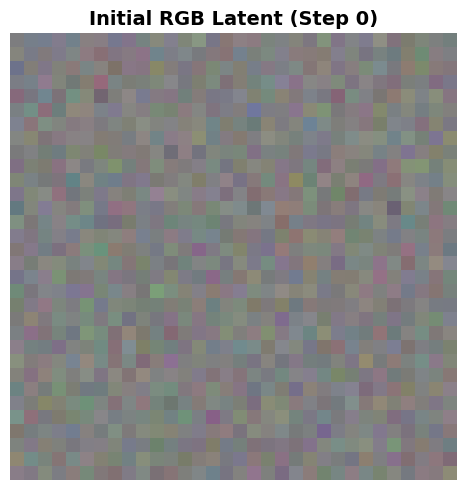

✓ Initialized RGB latent: torch.Size([3, 32, 32])
  R channel - Min: -0.337, Max: 0.271, Mean: 0.003
  G channel - Min: -0.364, Max: 0.371, Mean: 0.000
  B channel - Min: -0.339, Max: 0.364, Mean: -0.002


In [74]:
# Set random seed if specified
if random_seed is not None:
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

# Initialize RGB latent [3, H, W]
latent = torch.randn(3, image_size, image_size) * 0.1

latent = latent.to(device)
latent.requires_grad_(True)

# Helper function to convert latent to RGB image for display
def latent_to_rgb(latent_tensor):
    """Convert [3, H, W] tensor to [H, W, 3] numpy array for matplotlib, normalized to [0, 1]"""
    rgb = latent_tensor.detach().cpu().numpy()
    rgb = np.transpose(rgb, (1, 2, 0))  # [3, H, W] -> [H, W, 3]
    # Normalize from [-1.5, 1.5] to [0, 1]
    rgb = (rgb + 1.5) / 3.0
    rgb = np.clip(rgb, 0, 1)
    return rgb

# Visualize initial state
plt.figure(figsize=(5, 5))
plt.imshow(latent_to_rgb(latent))
plt.title('Initial RGB Latent (Step 0)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"✓ Initialized RGB latent: {latent.shape}")
print(f"  R channel - Min: {latent[0].min().item():.3f}, Max: {latent[0].max().item():.3f}, Mean: {latent[0].mean().item():.3f}")
print(f"  G channel - Min: {latent[1].min().item():.3f}, Max: {latent[1].max().item():.3f}, Mean: {latent[1].mean().item():.3f}")
print(f"  B channel - Min: {latent[2].min().item():.3f}, Max: {latent[2].max().item():.3f}, Mean: {latent[2].mean().item():.3f}")

## 3. Run Optimization with Snapshots

Watch the RGB latent evolve step by step!

In [75]:
# Reset latent (re-run cell above if you want new random init)
optimizer = torch.optim.Adam([latent], lr=learning_rate)

# Storage for snapshots
snapshots = []
snapshot_steps = []
loss_history = []

# Save initial state
snapshots.append(latent.detach().cpu().numpy().copy())
snapshot_steps.append(0)

print("Starting optimization...\n")

for step in range(num_steps):
    optimizer.zero_grad()
    
    # Compute all losses with InfoNCE parameters
    losses = compute_losses(
        latent,
        patch_size=infonce_patch_size,
        num_samples=infonce_num_samples,
        temperature=infonce_temperature,
        positive_radius=infonce_positive_radius,
        negative_radius=infonce_negative_radius
    )
    
    # Build weighted total loss
    total_loss = sum(losses[name] * weights[name] for name in losses if name in weights)
    
    # Optimize
    total_loss.backward()
    optimizer.step()
    
    # Clamp to valid range
    with torch.no_grad():
        latent.clamp_(-1.5, 1.5)
    
    loss_history.append(total_loss.item())
    
    # Save snapshot
    if (step + 1) % snapshot_interval == 0:
        snapshots.append(latent.detach().cpu().numpy().copy())
        snapshot_steps.append(step + 1)
        print(f"Step {step + 1:3d}/{num_steps}: Loss = {total_loss.item():.4f}")

# Save final state if not already saved
if num_steps % snapshot_interval != 0:
    snapshots.append(latent.detach().cpu().numpy().copy())
    snapshot_steps.append(num_steps)

print(f"\n✓ Optimization complete!")
print(f"  Captured {len(snapshots)} snapshots")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Initial loss: {loss_history[0]:.4f}")

Starting optimization...

Step  25/250: Loss = 0.3180
Step  50/250: Loss = 0.1590
Step  75/250: Loss = 0.1190
Step 100/250: Loss = 0.1093
Step 125/250: Loss = 0.1068
Step 150/250: Loss = 0.1059
Step 175/250: Loss = 0.1024
Step 200/250: Loss = 0.1010
Step 225/250: Loss = 0.1023
Step 250/250: Loss = 0.1010

✓ Optimization complete!
  Captured 11 snapshots
  Final loss: 0.1010
  Initial loss: 2.4664


## 4. Visualize Evolution

See all RGB snapshots in a grid

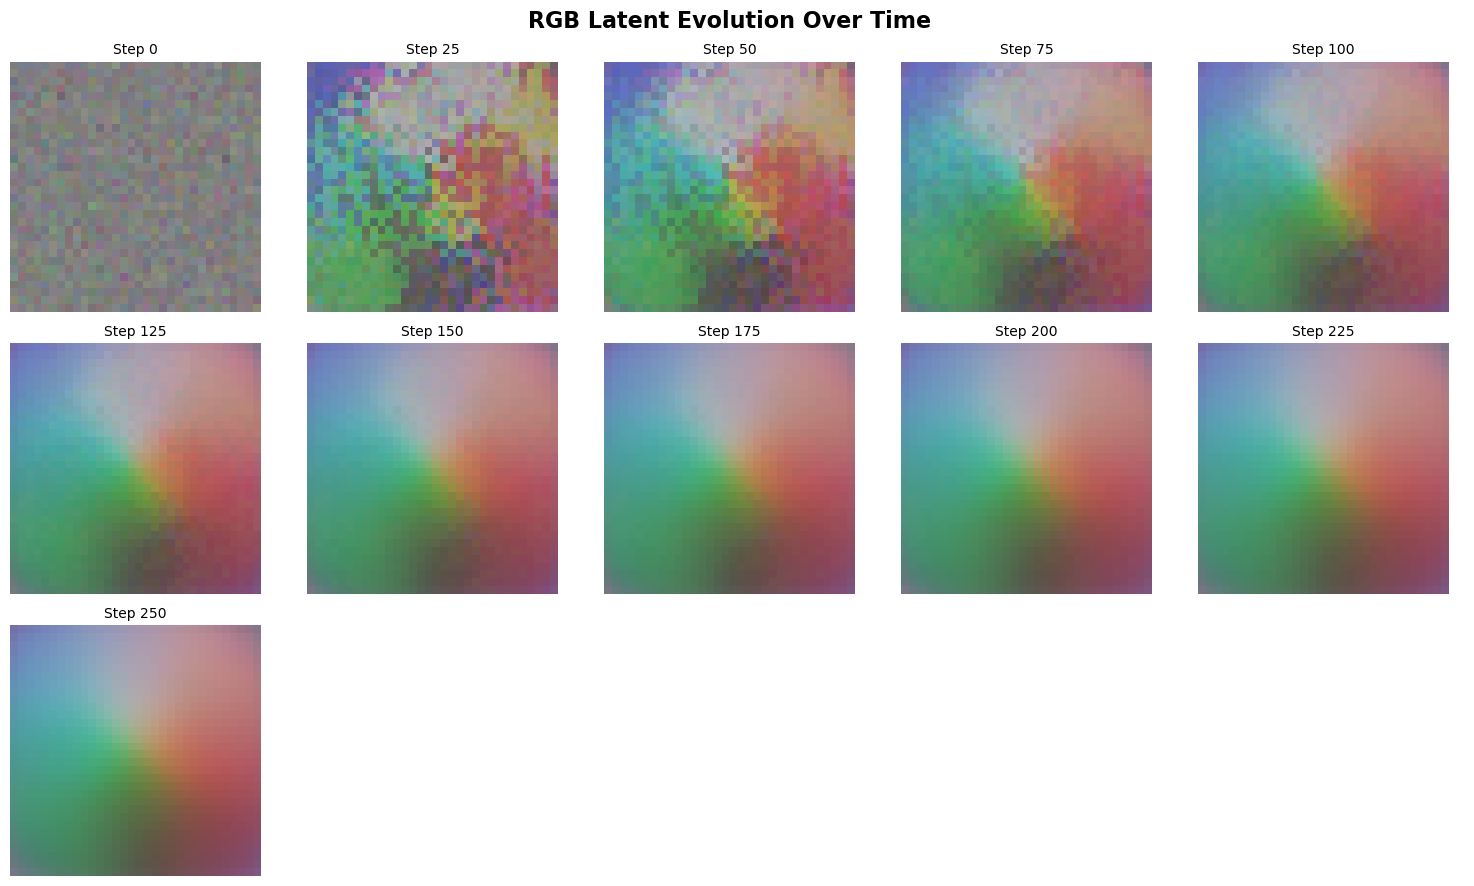


Evolution summary:
  Initial → Final: 0 → 250 steps
  You can see the transformation from random noise to structured colored shapes!


In [76]:
# Calculate grid size
num_snapshots = len(snapshots)
cols = min(5, num_snapshots)
rows = (num_snapshots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
if rows == 1:
    axes = axes.reshape(1, -1)
if cols == 1:
    axes = axes.reshape(-1, 1)

for idx, (snapshot, step) in enumerate(zip(snapshots, snapshot_steps)):
    row = idx // cols
    col = idx % cols
    
    ax = axes[row, col]
    
    # Convert to RGB image
    rgb = np.transpose(snapshot, (1, 2, 0))  # [3, H, W] -> [H, W, 3]
    rgb = (rgb + 1.5) / 3.0  # Normalize to [0, 1]
    rgb = np.clip(rgb, 0, 1)
    
    ax.imshow(rgb)
    ax.set_title(f'Step {step}', fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(num_snapshots, rows * cols):
    row = idx // cols
    col = idx % cols
    axes[row, col].axis('off')

plt.suptitle('RGB Latent Evolution Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nEvolution summary:")
print(f"  Initial → Final: {snapshot_steps[0]} → {snapshot_steps[-1]} steps")
print(f"  You can see the transformation from random noise to structured colored shapes!")

## 5. Plot Loss Curve

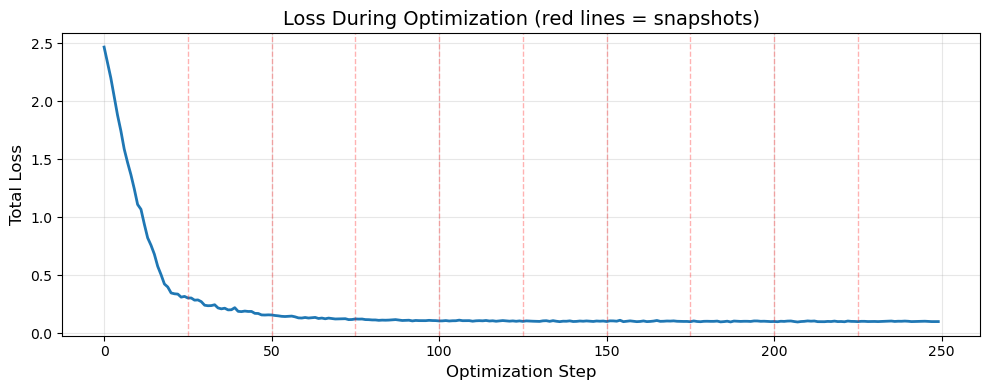

Loss reduction: 95.9%


In [77]:
plt.figure(figsize=(10, 4))
plt.plot(loss_history, linewidth=2)

# Mark snapshot points
for step in snapshot_steps[1:]:  # Skip initial
    if step < len(loss_history):
        plt.axvline(x=step, color='red', alpha=0.3, linestyle='--', linewidth=1)

plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)
plt.title('Loss During Optimization (red lines = snapshots)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss reduction: {(loss_history[0] - loss_history[-1]) / abs(loss_history[0]) * 100:.1f}%")

## 6. Side-by-Side Comparison

See initial vs final clearly

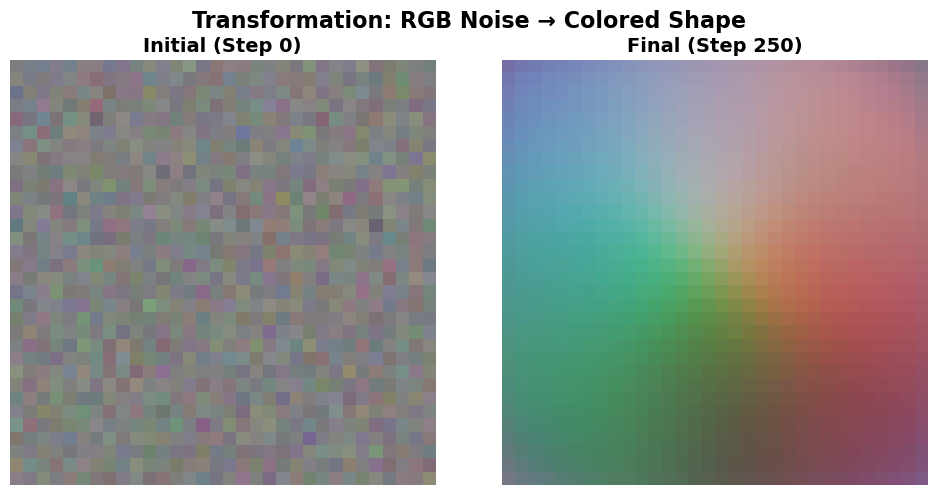

Initial latent:
  R channel - Min: -0.337, Max: 0.271, Mean: 0.003, Std: 0.099
  G channel - Min: -0.364, Max: 0.371, Mean: 0.000, Std: 0.101
  B channel - Min: -0.339, Max: 0.364, Mean: -0.002, Std: 0.100

Final latent:
  R channel - Min: -0.722, Max: 0.782, Mean: 0.009, Std: 0.516
  G channel - Min: -0.661, Max: 0.687, Mean: 0.051, Std: 0.369
  B channel - Min: -0.749, Max: 0.749, Mean: -0.032, Std: 0.466


In [78]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Helper to convert snapshot to RGB
def snapshot_to_rgb(snapshot):
    rgb = np.transpose(snapshot, (1, 2, 0))
    rgb = (rgb + 1.5) / 3.0
    rgb = np.clip(rgb, 0, 1)
    return rgb

# Initial
axes[0].imshow(snapshot_to_rgb(snapshots[0]))
axes[0].set_title(f'Initial (Step {snapshot_steps[0]})', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Final
axes[1].imshow(snapshot_to_rgb(snapshots[-1]))
axes[1].set_title(f'Final (Step {snapshot_steps[-1]})', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.suptitle('Transformation: RGB Noise → Colored Shape', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics for each channel
print("Initial latent:")
for c, name in enumerate(['R', 'G', 'B']):
    print(f"  {name} channel - Min: {snapshots[0][c].min():.3f}, Max: {snapshots[0][c].max():.3f}, Mean: {snapshots[0][c].mean():.3f}, Std: {snapshots[0][c].std():.3f}")

print("\nFinal latent:")
for c, name in enumerate(['R', 'G', 'B']):
    print(f"  {name} channel - Min: {snapshots[-1][c].min():.3f}, Max: {snapshots[-1][c].max():.3f}, Mean: {snapshots[-1][c].mean():.3f}, Std: {snapshots[-1][c].std():.3f}")

## 7. Analyze Individual Loss Components

See how each loss evolves

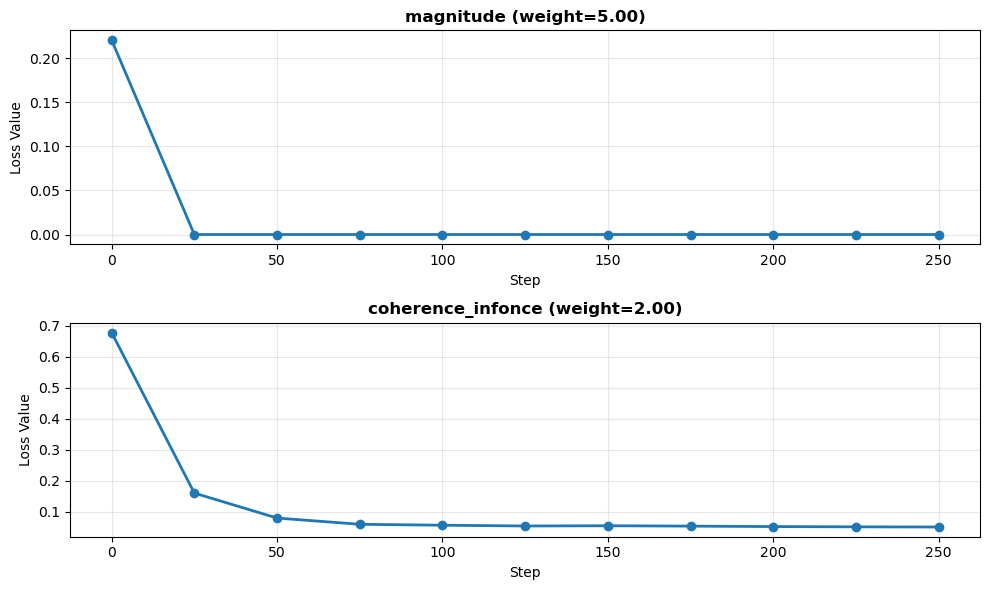

In [79]:
# Recompute losses at each snapshot
loss_components_history = {name: [] for name in weights.keys()}

for snapshot in snapshots:
    snapshot_tensor = torch.tensor(snapshot, dtype=torch.float32)
    losses = compute_losses(
        snapshot_tensor,
        patch_size=infonce_patch_size,
        num_samples=infonce_num_samples,
        temperature=infonce_temperature,
        positive_radius=infonce_positive_radius,
        negative_radius=infonce_negative_radius
    )
    for name in weights.keys():
        loss_components_history[name].append(losses[name].item())

# Plot active losses
active_losses = {name: values for name, values in loss_components_history.items() 
                if weights[name] > 0}

if active_losses:
    fig, axes = plt.subplots(len(active_losses), 1, figsize=(10, 3 * len(active_losses)))
    if len(active_losses) == 1:
        axes = [axes]
    
    for ax, (name, values) in zip(axes, active_losses.items()):
        ax.plot(snapshot_steps, values, linewidth=2, marker='o')
        ax.set_xlabel('Step', fontsize=10)
        ax.set_ylabel('Loss Value', fontsize=10)
        ax.set_title(f'{name} (weight={weights[name]:.2f})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No active losses to plot (all weights are 0)")

## 8. Visualize Individual RGB Channels

See how each color channel evolved independently

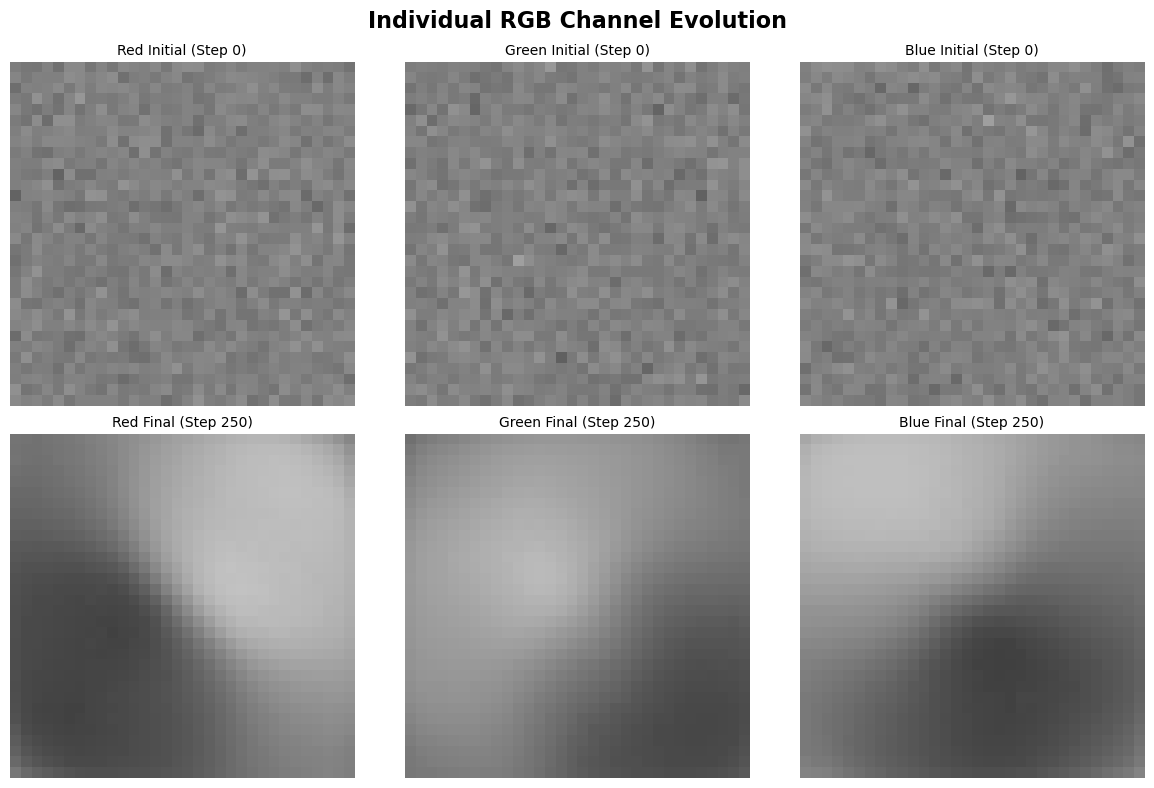


Note: Each channel evolves independently based on the InfoNCE loss.
The loss compares full RGB patches, so channels can have different patterns.


In [80]:
# Show initial and final for each channel
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

channel_names = ['Red', 'Green', 'Blue']

for c, name in enumerate(channel_names):
    # Initial
    axes[0, c].imshow(snapshots[0][c], cmap='gray', vmin=-1.5, vmax=1.5)
    axes[0, c].set_title(f'{name} Initial (Step {snapshot_steps[0]})', fontsize=10)
    axes[0, c].axis('off')
    
    # Final
    axes[1, c].imshow(snapshots[-1][c], cmap='gray', vmin=-1.5, vmax=1.5)
    axes[1, c].set_title(f'{name} Final (Step {snapshot_steps[-1]})', fontsize=10)
    axes[1, c].axis('off')

plt.suptitle('Individual RGB Channel Evolution', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNote: Each channel evolves independently based on the InfoNCE loss.")
print("The loss compares full RGB patches, so channels can have different patterns.")

## Experiments to Try

Go back to the "Configure Loss Weights and Parameters" cell and try:

### 1. Adjust InfoNCE Radii

**Smaller positive radius** (tighter coherence):
```python
infonce_positive_radius = 2.0
infonce_negative_radius = 8.0
```
**Expected**: More fine-grained patterns, smaller colored regions

**Larger positive radius** (broader coherence):
```python
infonce_positive_radius = 5.0
infonce_negative_radius = 15.0
```
**Expected**: Larger, more uniform colored regions

### 2. Adjust InfoNCE Temperature

**Lower temperature** (sharper distinctions):
```python
infonce_temperature = 0.5
```
**Expected**: Stronger enforcement of similarity/dissimilarity

**Higher temperature** (softer distinctions):
```python
infonce_temperature = 2.0
```
**Expected**: More gradual color transitions

### 3. Adjust Patch Size

**Smaller patches** (local detail):
```python
infonce_patch_size = 2
```
**Expected**: Finer textures, more detailed patterns

**Larger patches** (global structure):
```python
infonce_patch_size = 5
```
**Expected**: Smoother, more uniform regions

### 4. Vary Loss Weights

**Stronger coherence**:
```python
'magnitude': 5.0,
'coherence_infonce': 5.0,
```
**Expected**: Very smooth, homogeneous colored regions

**Weaker coherence**:
```python
'magnitude': 5.0,
'coherence_infonce': 0.5,
```
**Expected**: More varied, less coherent patterns

### 5. Change Image Size

Try different resolutions:
```python
image_size = 64  # Higher resolution
```
**Note**: This will be slower but produce more detailed patterns

### 6. More Optimization Steps

```python
num_steps = 500
```
**Expected**: More refined, converged patterns